In [2]:
import struct
import sys
import serial
import binascii
import time
import numpy as np
import math

import os
import datetime

# Local File Imports
from parseTLVs import *
from gui_common import *
from parse_ADC_data import readFrameHeader

In [16]:
binFileName = "pHistBytes"
number_of_files = 6
numAntennas = 3

# declaring TLV types compatible for ADC data stream
MMWDEMO_OUTPUT_EXT_MSG_ADC_SAMPLES = 316

# Set UART TLV Structures
hex_values = np.array([0x0102, 0x0304, 0x0506, 0x0708], dtype=np.uint16)
syncPatternUINT64 = hex_values.view(np.uint64)
syncPatternUINT8 = hex_values.view(np.uint8)

# defining header structure
frameHeaderStructType = np.dtype([
    ('sync', np.uint64),
    ('version', np.uint32),
    ('packetLength', np.uint32),
    ('platform', np.uint32),
    ('frameNumber', np.uint32),
    ('timeinCPUcycles', np.uint32),
    ('numDetectObject', np.uint32),
    ('numTLVs', np.uint32),
    ('subframe', np.uint32)
])

tlvHeaderStruct = np.dtype([
    ('type', np.uint32),
    ('length', np.uint32)
])

# header length
frameHeaderLengthInBytes = frameHeaderStructType.itemsize
tlvHeaderLengthInBytes = tlvHeaderStruct.itemsize

# Frame history structure
frameStatStruct = np.dtype([
    ('targetFrameNum', np.uint32),
    ('header', frameHeaderStructType),
    ('bytes', np.uint32),
    ('adcSamples', np.int16, (numAntennas,256))
])

# Function to read the frame header
def readFrameHeader(fid, frameHeaderLengthInBytes, syncPatternUINT8):
    lostSync = True
    outOfSyncBytes = 0
    while lostSync:
        syncPatternFound = True
        for n in range(8):
            rxByte = fid.read(1)
            if not rxByte:
                return None, 0, 0  # End of file
            rxByte = struct.unpack('<B', rxByte)[0]
            if rxByte != syncPatternUINT8[n]:
                syncPatternFound = False
                outOfSyncBytes += 1
                break
        if syncPatternFound:
            lostSync = False
            header = fid.read(frameHeaderLengthInBytes - 8)
            header = struct.unpack(f'<{frameHeaderLengthInBytes - 8}B', header)
            header = np.asarray(header, dtype=np.uint8)
            header = np.concatenate((syncPatternUINT8, header))
            # header = struct.unpack('<Q', syncPatternUINT8 + header)[0]
            return header, frameHeaderLengthInBytes, outOfSyncBytes
        
# IWRL6432 Out-of-box demo packets
MMWDEMO_OUTPUT_EXT_MSG_DETECTED_POINTS                  = 301
MMWDEMO_OUTPUT_EXT_MSG_RANGE_PROFILE_MAJOR              = 302
MMWDEMO_OUTPUT_EXT_MSG_RANGE_PROFILE_MINOR              = 303
MMWDEMO_OUTPUT_EXT_MSG_RANGE_AZIMUT_HEAT_MAP_MAJOR      = 304
MMWDEMO_OUTPUT_EXT_MSG_RANGE_AZIMUT_HEAT_MAP_MINOR      = 305
MMWDEMO_OUTPUT_MSG_EXT_STATS                            = 306
MMWDEMO_OUTPUT_EXT_MSG_PRESENCE_INFO                    = 307
MMWDEMO_OUTPUT_EXT_MSG_TARGET_LIST                      = 308
MMWDEMO_OUTPUT_EXT_MSG_TARGET_INDEX                     = 309
MMWDEMO_OUTPUT_EXT_MSG_MICRO_DOPPLER_RAW_DATA           = 310
MMWDEMO_OUTPUT_EXT_MSG_MICRO_DOPPLER_FEATURES           = 311
MMWDEMO_OUTPUT_EXT_MSG_RADAR_CUBE_MAJOR                 = 312
MMWDEMO_OUTPUT_EXT_MSG_RADAR_CUBE_MINOR                 = 313
MMWDEMO_OUTPUT_EXT_MSG_POINT_CLOUD_INDICES              = 314
MMWDEMO_OUTPUT_EXT_MSG_ENHANCED_PRESENCE_INDICATION     = 315
MMWDEMO_OUTPUT_EXT_MSG_ADC_SAMPLES                      = 316
MMWDEMO_OUTPUT_EXT_MSG_CLASSIFIER_INFO                  = 317
MMWDEMO_OUTPUT_EXT_MSG_RX_CHAN_COMPENSATION_INFO        = 318

def parseRangeProfileTLV(tlvData):
    rangeProfile = []
    rangeDataStruct = 'I' # Every range bin gets a uint32_t
    rangeDataSize = struct.calcsize(rangeDataStruct)

    numRangeBins = int(len(tlvData)/rangeDataSize)
    for i in range(numRangeBins):
        # Read in single range bin data
        try:
            rangeBinData = struct.unpack(rangeDataStruct, tlvData[:rangeDataSize])
        except:
            print(f'Error: Range Profile TLV Parser Failed To Parse Range Bin Number ${i}')
            raise
            break
        rangeProfile.append(rangeBinData[0])

        # Move to next value
        tlvData = tlvData[rangeDataSize:]
    return rangeProfile

# Point Cloud Ext TLV from SDK for IWRL6432
def parsePointCloudExtTLV(tlvData, tlvLength, pointCloud):
    pUnitStruct = '4f2h' # Units for the 5 results to decompress them
    pointStruct = '4h2B' # x y z doppler snr noise
    pUnitSize = struct.calcsize(pUnitStruct)
    pointSize = struct.calcsize(pointStruct)

    # Parse the decompression factors
    try:
        pUnit = struct.unpack(pUnitStruct, tlvData[:pUnitSize])
    except:
            print('Error: Point Cloud TLV Parser Failed')
            return 0, pointCloud
    # Update data pointer
    tlvData = tlvData[pUnitSize:]

    # Parse each point
    numPoints = int((tlvLength-pUnitSize)/pointSize)
    for i in range(numPoints):
        try:
            x, y, z, doppler, snr, noise = struct.unpack(pointStruct, tlvData[:pointSize])
        except:
            numPoints = i
            print('Error: Point Cloud TLV Parser Failed')
            break
        
        tlvData = tlvData[pointSize:]
        # Decompress values
        pointCloud[i,0] = x * pUnit[0]          # x
        pointCloud[i,1] = y * pUnit[0]          # y
        pointCloud[i,2] = z * pUnit[0]          # z
        pointCloud[i,3] = doppler * pUnit[1]    # Dopper
        pointCloud[i,4] = snr * pUnit[2]        # SNR
        pointCloud[i,5] = noise * pUnit[3]      # Noise
    return numPoints, pointCloud

def parseExtStatsTLV(tlvData, tlvLength):
    extStatsStruct = '2I8H' # Units for the 5 results to decompress them
    extStatsStructSize = struct.calcsize(extStatsStruct)
    # Parse the decompression factors
    try:
        interFrameProcTime, transmitOutTime, power1v8, power3v3, \
        power1v2, power1v2RF, tempRx, tempTx, tempPM, tempDIG = \
        struct.unpack(extStatsStruct, tlvData[:extStatsStructSize])
    except:
            print('Error: Ext Stats Parser Failed')
            return 0

    tlvData = tlvData[extStatsStructSize:]

    procTimeData = {}
    powerData = {}
    tempData = {}
    # print("IFPT : " + str(interFrameProcTime))

    procTimeData['interFrameProcTime'] = interFrameProcTime
    procTimeData['transmitOutTime'] = transmitOutTime

    powerData['power1v8'] = power1v8
    powerData['power3v3'] = power3v3
    powerData['power1v2'] = power1v2
    powerData['power1v2RF'] = power1v2RF

    tempData['tempRx'] = tempRx
    tempData['tempTx'] = tempTx
    tempData['tempPM'] = tempPM
    tempData['tempDIG'] = tempDIG

    return procTimeData, powerData, tempData

In [17]:
def parse_ADC(binFilePath):
    toreturn = np.array([]) #file to be returned
    targetFrameNum = 0
    # Open and read using the method from the visualizer
    for file_num in range(1, number_of_files + 1):
        thisBinFileName = os.path.join(binFilePath, f"{binFileName}_{file_num}.bin")
        print(f"processing file: {thisBinFileName}")

        #open file and read al the ADC data
        with open(thisBinFileName, 'rb') as fid:
            lostSync = False
            gotHeader = False
            while True:
                outputDict = {}
                if not gotHeader:
                    # Read the header first
                    rxHeader, byteCount, outOfSyncBytes = readFrameHeader(fid, frameHeaderLengthInBytes, syncPatternUINT8)
                    gotHeader = True

                # Double check the header size
                if byteCount != frameHeaderLengthInBytes:
                    reason = 'Header Size is wrong'
                    lostSync = True
                    break

                # Double check the sync pattern
                magicBytes = np.frombuffer(rxHeader[:8], dtype=np.uint64)
                if not np.array_equal(magicBytes, syncPatternUINT64):
                    reason = 'No SYNC pattern'
                    lostSync = True
                    break

                # Parse the header
                frameHeader = np.frombuffer(rxHeader, dtype=frameHeaderStructType)

                if gotHeader:
                    print(f"frame number is: {frameHeader['frameNumber'][0]}")
                    if frameHeader['frameNumber'][0] >= targetFrameNum:
                        # We have a valid header
                        targetFrameNum = frameHeader['frameNumber'][0]
                        frameNum = frameHeader['frameNumber'][0]
                        if outOfSyncBytes > 0:
                            print(f'Found sync at frame {targetFrameNum}({frameNum}). Discarded out of sync bytes: {outOfSyncBytes}')
                        gotHeader = False
                    else:
                        reason = 'Old Frame'
                        gotHeader = False
                        lostSync = True
                        break

                # Start processing the header
                outputDict['targetFrameNum'] = targetFrameNum
                outputDict['header'] = frameHeader
                dataLength = frameHeader['packetLength'] - frameHeaderLengthInBytes
                outputDict['bytes'] = dataLength
                numDetectObject = frameHeader['numDetectObject'][0]

                if dataLength[0] > 0:
                    # Read all packet
                    rxData = np.fromfile(fid, dtype=np.uint8, count=dataLength[0])
                    if rxData.size != dataLength:
                        reason = 'Data Size is wrong'
                        lostSync = True
                        break
                    offset = 0

                    # TLV Parsing
                    for nTlv in range(frameHeader['numTLVs'][0]):
                        tlvType = np.frombuffer(rxData[offset:offset+4], dtype=np.uint32)[0]
                        tlvLength = np.frombuffer(rxData[offset+4:offset+8], dtype=np.uint32)[0]
                        if tlvLength + offset > dataLength:
                            reason = 'TLV Size is wrong'
                            lostSync = True
                            break
                        offset += tlvHeaderLengthInBytes
                        valueLength = tlvLength

                        tlv_data = rxData[offset:offset+valueLength]

                        if tlvType == MMWDEMO_OUTPUT_EXT_MSG_ADC_SAMPLES:
                            adcSamples = np.frombuffer(tlv_data, dtype=np.int16)
                            adcSamples = np.reshape(adcSamples, (-1, numAntennas)).T
                            offset += valueLength

                        elif tlvType == MMWDEMO_OUTPUT_EXT_MSG_DETECTED_POINTS:
                            point_cloud = np.zeros((numDetectObject, 7), np.float64)
                            outputDict['numDetectedPoints'], outputDict['pointCloud'] = parsePointCloudExtTLV(tlv_data, tlvLength, pointCloud=point_cloud)
                            offset += valueLength

                        elif tlvType == MMWDEMO_OUTPUT_EXT_MSG_RANGE_PROFILE_MAJOR:
                            outputDict['rangeProfile'] = parseRangeProfileTLV(tlvData=rxData[offset:offset+valueLength])
                            offset += valueLength

                        elif tlvType == MMWDEMO_OUTPUT_MSG_EXT_STATS:
                            a, b, c = parseExtStatsTLV(tlv_data, tlvLength)

                        else:
                            print(tlvType)
                            reason = 'TLV Type is wrong or not supported'
                            lostSync = True
                            break
                        # exit()

                    if lostSync:
                        print(reason)
                        break

                toreturn = np.append(toreturn, outputDict)
    # if output_file:
    #     np.save(output_file, toreturn, allow_pickle=True)
    return toreturn

In [18]:
binFilePath = "/Users/ryuokubo/Library/CloudStorage/Box-Box/CS437_TI_radar/Industrial_Visualizer/binData/10_06_2023_11_04_35/"
parse_ADC(binFilePath)

processing file: /Users/ryuokubo/Library/CloudStorage/Box-Box/CS437_TI_radar/Industrial_Visualizer/binData/10_06_2023_11_04_35/pHistBytes_1.bin
frame number is: 1
frame number is: 2
frame number is: 3
frame number is: 4
frame number is: 5
frame number is: 6
frame number is: 7
frame number is: 8
frame number is: 9
frame number is: 10
frame number is: 11
frame number is: 12
frame number is: 13
frame number is: 14
frame number is: 15
frame number is: 16
frame number is: 17
frame number is: 18
frame number is: 19
frame number is: 20
frame number is: 21
frame number is: 22
frame number is: 23
frame number is: 24
frame number is: 25
frame number is: 26
frame number is: 27
frame number is: 28
frame number is: 29
frame number is: 30
frame number is: 31
frame number is: 32
frame number is: 33
frame number is: 34
frame number is: 35
frame number is: 36
frame number is: 37
frame number is: 38
frame number is: 39
frame number is: 40
frame number is: 41
frame number is: 42
frame number is: 43
frame

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ryuokubo/Library/CloudStorage/Box-Box/CS437_TI_radar/Industrial_Visualizer/binData/10_06_2023_11_04_35/pHistBytes_3.bin'

In [4]:
# Constants for parsing frame header
headerStruct = 'Q8I'
frameHeaderLen = struct.calcsize(headerStruct)
tlvHeaderLength = 8

In [5]:
# Define the function's output structure and initialize error field to no error
outputDict = {}
outputDict['error'] = 0

# A sum to track the frame packet length for verification for transmission integrity 
totalLenCheck = 0   

In [49]:
numAntennas = 3

# defining header structure
frameHeaderStructType = np.dtype([
    ('sync', np.uint64),
    ('version', np.uint32),
    ('packetLength', np.uint32),
    ('platform', np.uint32),
    ('frameNumber', np.uint32),
    ('timeinCPUcycles', np.uint32),
    ('numDetectObject', np.uint32),
    ('numTLVs', np.uint32),
    ('subframe', np.uint32)
])

tlvHeaderStruct = np.dtype([
    ('type', np.uint32),
    ('length', np.uint32)
])

# header length
frameHeaderLengthInBytes = frameHeaderStructType.itemsize
tlvHeaderLengthInBytes = tlvHeaderStruct.itemsize

# Frame history structure
frameStatStruct = np.dtype([
    ('targetFrameNum', np.uint32),
    ('header', frameHeaderStructType),
    ('bytes', np.uint32),
    ('adcSamples', np.int16, (numAntennas,256))
])

# Set UART TLV Structures
hex_values = np.array([0x0102, 0x0304, 0x0506, 0x0708], dtype=np.uint16)
syncPatternUINT64 = hex_values.view(np.uint64)
syncPatternUINT8 = hex_values.view(np.uint8)

In [50]:
binFilePath = "/Users/ryuokubo/Library/CloudStorage/Box-Box/CS437_TI_radar/Industrial_Visualizer/binData/10_06_2023_11_04_35/"
binFileName = "pHistBytes"
thisBinFileName = os.path.join(binFilePath, f"{binFileName}_{1}.bin")

In [51]:
with open(thisBinFileName, 'rb') as fid:
    rxHeader, byteCount, outOfSyncBytes = readFrameHeader(fid, frameHeaderLengthInBytes, syncPatternUINT8)
    frameHeader = np.frombuffer(rxHeader, dtype=frameHeaderStructType)
    dataLength = frameHeader['packetLength'] - frameHeaderLengthInBytes
    rxData = np.fromfile(fid, dtype=np.uint8, count=dataLength[0])

In [62]:
numDetectObject = frameHeader['numDetectObject']
numDetectObject

array([6], dtype=uint32)

In [52]:
offset = 0
tlvType = np.frombuffer(rxData[offset:offset+4], dtype=np.uint32)[0]
tlvLength = np.frombuffer(rxData[offset+4:offset+8], dtype=np.uint32)[0]

In [53]:
offset += tlvHeaderLengthInBytes

In [54]:
valueLength = tlvLength

In [60]:
tlv_data = rxData[offset:offset+valueLength]


In [71]:

if tlvType == MMWDEMO_OUTPUT_EXT_MSG_DETECTED_POINTS:
    print("here")
    a,b = parsePointCloudExtTLV(tlv_data, tlvLength, pointCloud=point_cloud)
elif tlvType == MMWDEMO_OUTPUT_EXT_MSG_RANGE_PROFILE_MAJOR:
    a = parseRangeProfileTLV(tlvData=rxData[offset:offset+valueLength])

20


In [72]:
a

[302,
 512,
 20462,
 136418,
 443493,
 491816,
 162407,
 57049,
 39408,
 13251,
 6809,
 5564,
 4466,
 5375,
 9858,
 9760,
 6920,
 5510,
 5208,
 4023]

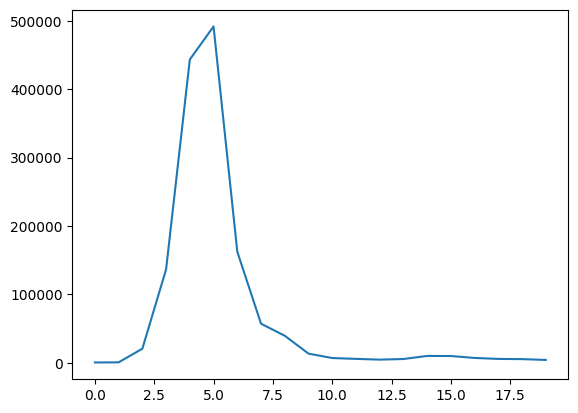

In [73]:
import matplotlib.pyplot as plt
plt.plot(a)

In [74]:
offset += tlvLength

In [75]:
tlvType = np.frombuffer(rxData[offset:offset+4], dtype=np.uint32)[0]
tlvLength = np.frombuffer(rxData[offset+4:offset+8], dtype=np.uint32)[0]

In [76]:
tlvType

4185